In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.8 MB/s eta 0:00:00


In [124]:
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
# from bertviz import head_view
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from progressbar import progressbar as pb

Tokenizer and model

In [125]:
model_name = 'bert-large-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
model = AutoModel.from_pretrained(model_name,  output_attentions=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name,  output_attentions=True)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Position Features

In [126]:
def get_attention_weights_and_features(sentence):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = 'cpu'
    # Tokenize input sentence
    tokens = tokenizer.tokenize(sentence)
    inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, return_tensors='pt').to(device)
    # Forward pass through the model
    outputs = model(**inputs)

    # Get attention weights, positions, and embeddings for all tokens
    attentions = outputs.attentions[-1]
    attentions = attentions.squeeze(0).permute(1, 2, 0).reshape(attentions.shape[2], attentions.shape[3], attentions.shape[1]).to("cpu")
    # List of attention matrices for each layer
    positions = torch.arange(len(tokens)+2)  # Positions of tokens
    embeddings = outputs.last_hidden_state.squeeze(0).to("cpu")  # Token embeddings

    return attentions, positions, embeddings, tokens

# Example usage
sentence = "The quick brown fox jumps over the lazy dog every time."
attention_weights, token_positions, token_embeddings, tokens = get_attention_weights_and_features(sentence)

print("Token Positions:")
print(token_positions)

print("Token Embeddings:")
print(token_embeddings.shape)

Token Positions:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
Token Embeddings:
torch.Size([14, 1024])


In [127]:
glue_dataset = load_dataset("glue", "cola", split="validation[:600]")
glue_dataset

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 600
})

In [128]:
# glue_dataset = load_dataset("glue", "cola")

results = {'attention_weights': [], 'token_positions': [], 'token_re_positions': [], 'token_embeddings': []}
for example in pb(glue_dataset):
    sentence = example["sentence"]
    attention_weights, token_positions, token_embeddings, tokens = get_attention_weights_and_features(sentence)
    results['attention_weights'].append(attention_weights)
    results['token_positions'].append(token_positions)
    results['token_re_positions'].append(token_positions.max() - token_positions)
    results['token_embeddings'].append(token_embeddings)

len(results['token_positions'])

100% (600 of 600) |######################| Elapsed Time: 0:00:40 Time:  0:00:40


600

In [129]:
def features_to_dataset(token_positions, token_re_positions, token_embeddings, attention_weights):
  # Create a dictionary to hold the data
  data = {'position': token_positions, 're_position': token_re_positions, 'embedding': token_embeddings.detach().numpy().tolist()}

  embeddings = token_embeddings.detach().numpy()

  # Add embedding columns to the dictionary
  for i in range(embeddings.shape[1]):
      data[f'embedding_{i+1}'] = embeddings[:, i]



  # data['embedding'] = embeddings.squeeze()

  embedding_cols = [f'embedding_{i+1}' for i in range(embeddings.shape[1])]
  # Create the DataFrame
  df = pd.DataFrame(data)

  shape = attention_weights.shape

  attention_weights_to_tokens = attention_weights.reshape(-1, shape[0]).T.detach().numpy()
  to_cols = [f'to_{i+1}_head_{j+1}' for i in range(shape[1]) for j in range(shape[2])]
  attention_weights_to_tokens_df = pd.DataFrame(attention_weights_to_tokens, columns=to_cols)
  combined_df_1 = pd.concat([df, attention_weights_to_tokens_df], axis=1)

  # attention_weights_to_tokens_df = pd.DataFrame(attention_weights, columns='attention_weights')
  # combined_df_1 = pd.concat([df, attention_weights_to_tokens_df], axis=1)


  # Transpose the reshaped attention weights matrix to get the weights from other tokens to each token
  attention_weights_from_tokens = attention_weights.reshape(shape[0], -1).detach().numpy()
  from_cols = [f'from_{i+1}_head_{j+1}' for i in range(shape[1]) for j in range(shape[2])]
  attention_weights_from_tokens_df = pd.DataFrame(attention_weights_from_tokens, columns = from_cols )
  combined_df = pd.concat([combined_df_1, attention_weights_from_tokens_df], axis=1)

  return combined_df



In [130]:
df = features_to_dataset(results['token_positions'][0], results['token_re_positions'][0], results['token_embeddings'][0], results['attention_weights'][0])
for i in range(1, len(results['attention_weights'])):
  df = pd.concat([df, features_to_dataset(results['token_positions'][i], results['token_re_positions'][i], results['token_embeddings'][i], results['attention_weights'][i])], axis=0)

In [131]:
correlation_matrix = df.corr()

<ipython-input-131-68bbfff3c4eb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [132]:
correlation_matrix.columns

Index(['position', 're_position', 'embedding_1', 'embedding_2', 'embedding_3',
       'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7',
       'embedding_8',
       ...
       'from_35_head_7', 'from_35_head_8', 'from_35_head_9', 'from_35_head_10',
       'from_35_head_11', 'from_35_head_12', 'from_35_head_13',
       'from_35_head_14', 'from_35_head_15', 'from_35_head_16'],
      dtype='object', length=2146)

In [133]:
embedding_cols = list(df.columns[df.columns.str.contains("embedding_")])
# embedding_cols = ['embedding']
to_cols = list(df.columns[df.columns.str.contains("to")])
head_cols = [list(df[to_cols].columns[df[to_cols].columns.str.contains(f'head_{i}$')]) for i in range(1, 17)]
from_cols = list(df.columns[df.columns.str.contains("from")])

## Кореляция c позицией в каждой голове

### для каждой головы

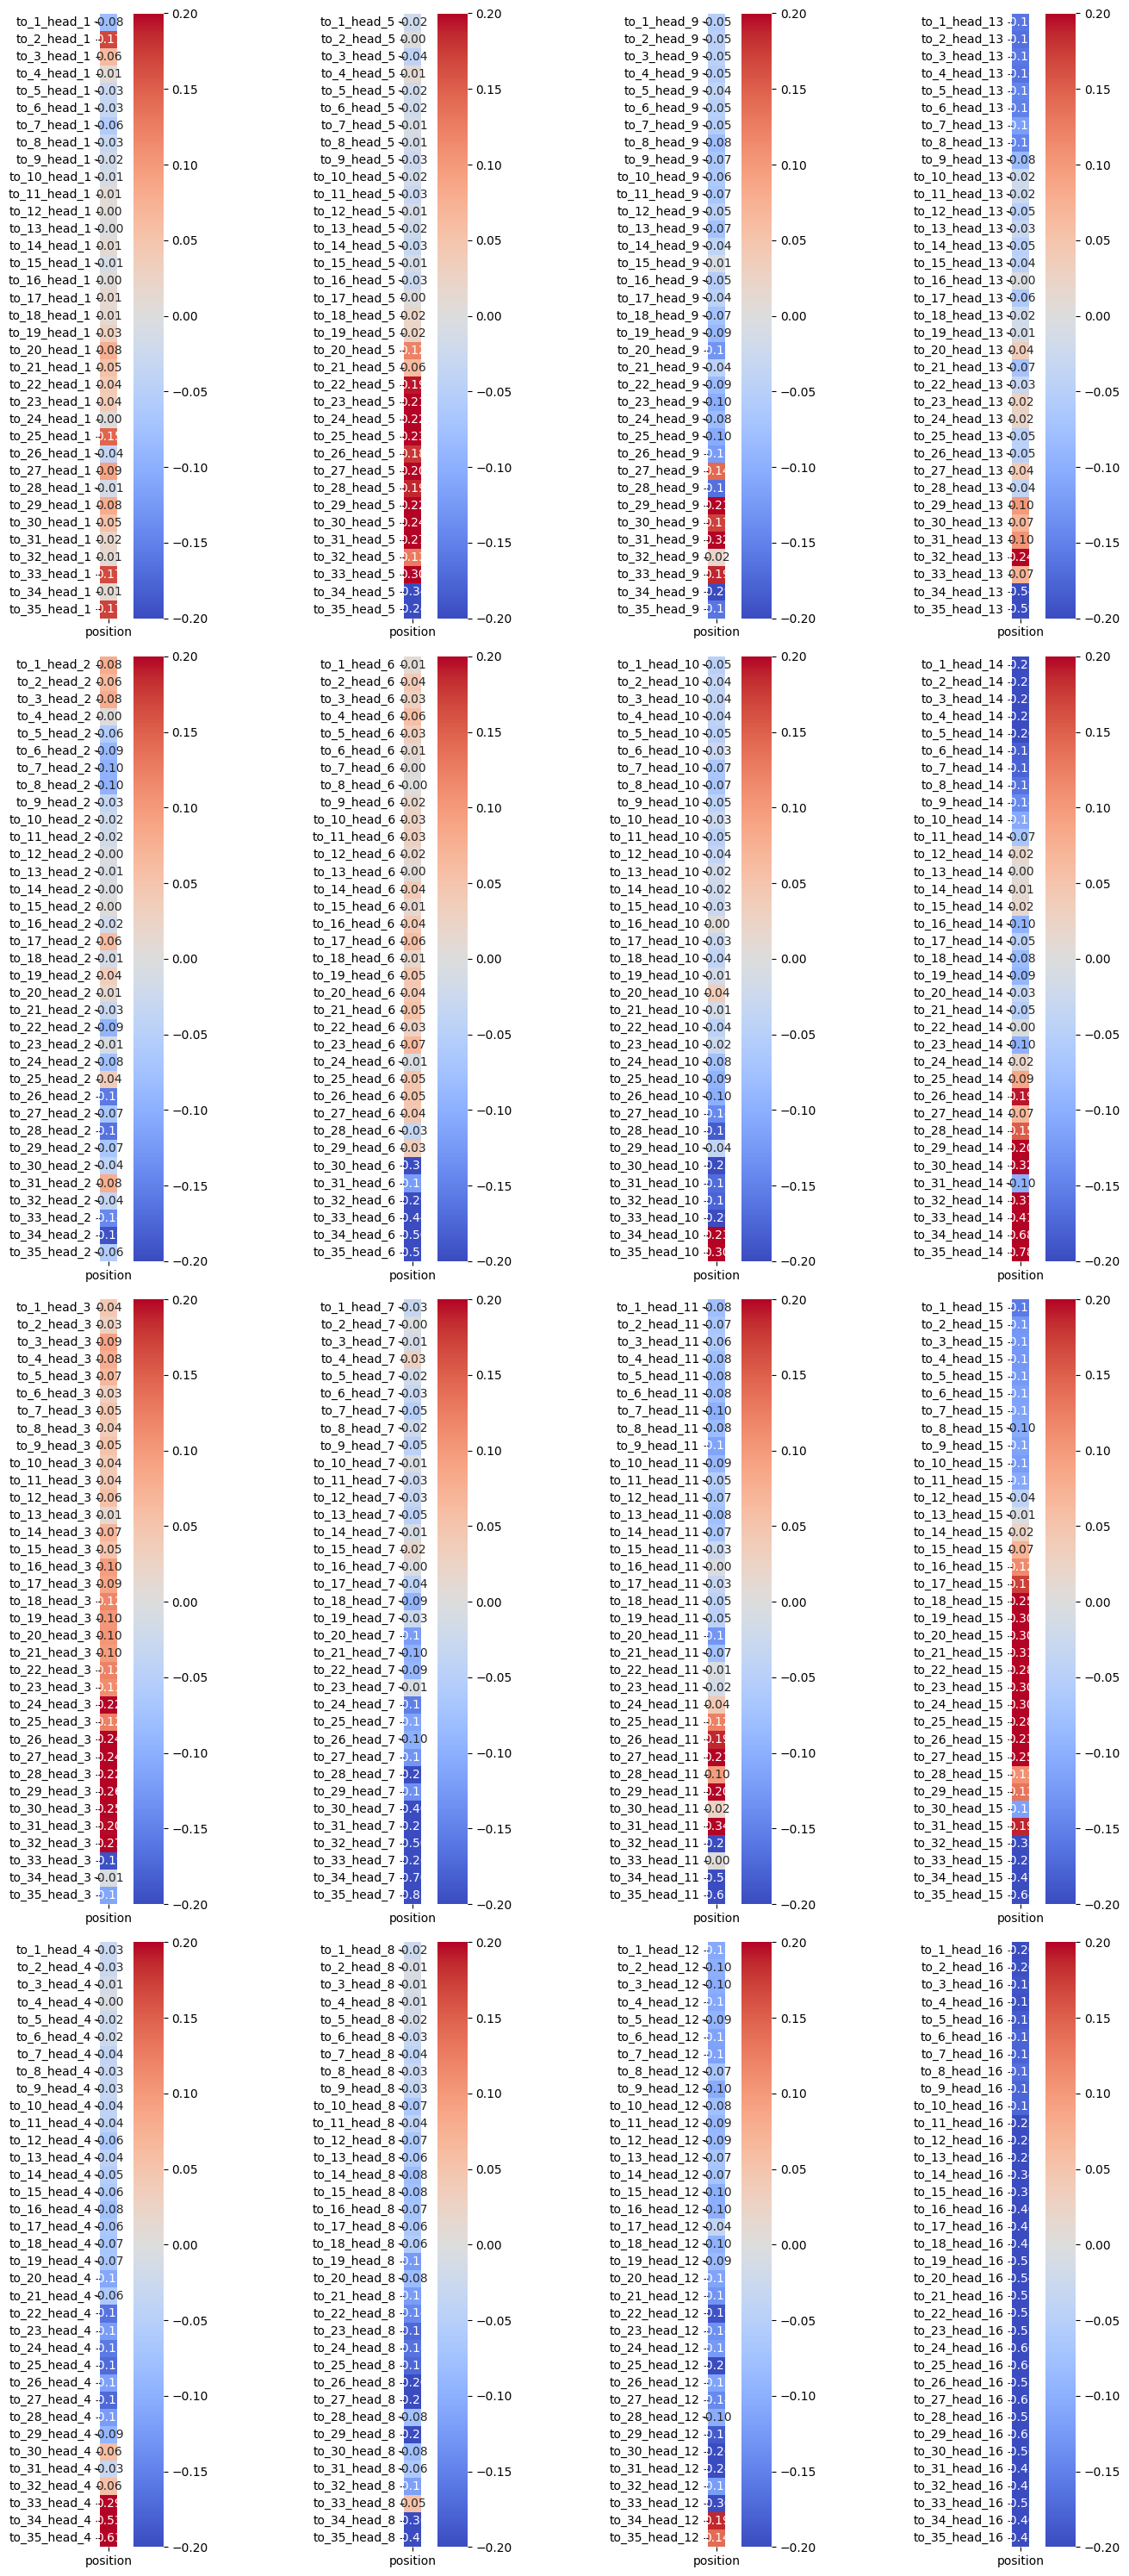

In [158]:
correlation_matrix_new = correlation_matrix.drop(["position"]+ embedding_cols, axis = 0)
correlation_matrix_new = correlation_matrix_new.drop(to_cols+from_cols, axis = 1)
# Calculate the average correlation within each group
fig, axes = plt.subplots(4, 4, figsize=(15, 30))
# plt.subplots_adjust(wspace=0.5)

heads_mean = []
for num, i in enumerate(head_cols):
  heads_mean.append(np.abs(correlation_matrix.loc[i, 'position']).mean())
  # # Plot the correlation heatmap for the subset
  # plt.figure(figsize=(5, 10))
  sns.heatmap(correlation_matrix.loc[i, ['position']], ax = axes[num%4, num//4], annot=True, cmap='coolwarm' , fmt=".2f", square=True, vmin=-0.2, vmax=0.2)
  axes[num%4, num//4].set_aspect('equal')  # Equal aspect ratio
  # axes[num%4, num//4].set_yticks([])
  # axes[num%4, num//4].set_yticklabels(axes[num%4, num//4].get_yticklabels(), size=10)  # Adjust size as needed

plt.tight_layout()
plt.show()

## Кореляция c позицией в каждой голове

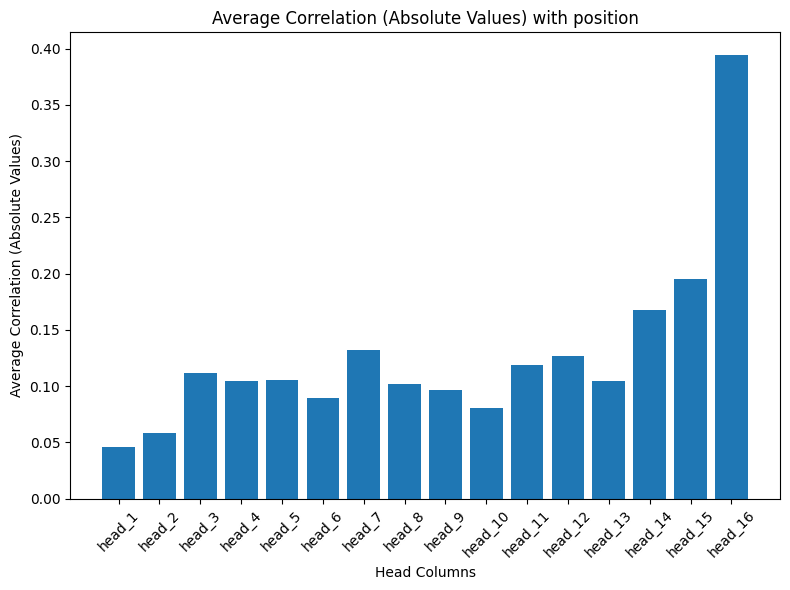

In [159]:
plt.figure(figsize=(8, 6))
plt.bar([f'head_{i}' for i in range(1, len(head_cols)+1)], heads_mean)
plt.xlabel('Head Columns')
plt.ylabel('Average Correlation (Absolute Values)')
plt.title('Average Correlation (Absolute Values) with position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Корреляция с тензорами на которые смотрим
(по очевидным причинам должна быть высокая)

In [ ]:
correlation_matrix.columns

Index(['position', 're_position', 'embedding_1', 'embedding_2', 'embedding_3',
       'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7',
       'embedding_8',
       ...
       'from_35_head_7', 'from_35_head_8', 'from_35_head_9', 'from_35_head_10',
       'from_35_head_11', 'from_35_head_12', 'from_35_head_13',
       'from_35_head_14', 'from_35_head_15', 'from_35_head_16'],
      dtype='object', length=2146)

<ipython-input-91-b43c2e890481>:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  subset_correlation_matrix = correlation_matrix_from.loc[to_from_columns, embedding_columns]


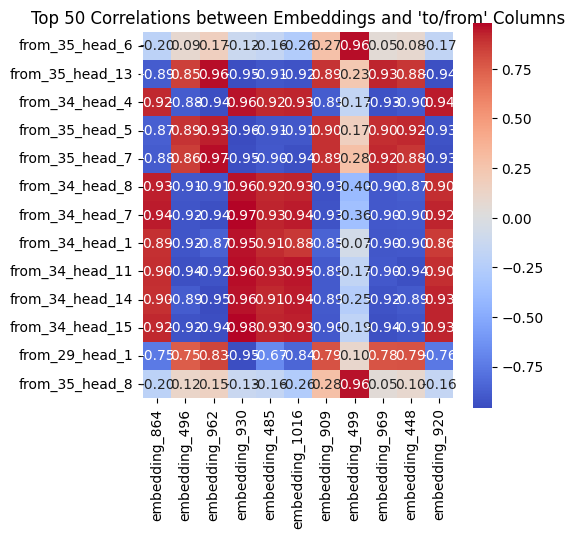

In [ ]:
correlation_matrix_from = correlation_matrix.drop(["position"]+['re_position']+ embedding_cols+to_cols, axis = 0)
correlation_matrix_from = correlation_matrix_from.drop(from_cols+to_cols, axis = 1)

# Filter the correlation matrix to select top correlations
N = 50  # Number of top correlations to visualize
top_correlations = correlation_matrix_from[embedding_cols].abs().unstack().sort_values(ascending=False)[:N]

# Extract the column and row names of the top correlations
top_correlation_names = top_correlations.index
embedding_columns = set([name[0] for name in top_correlation_names])
to_from_columns = set([name[1] for name in top_correlation_names[:20]])

# Create a subset correlation matrix with the top correlations
subset_correlation_matrix = correlation_matrix_from.loc[to_from_columns, embedding_columns]

# Plot the correlation heatmap for the subset
plt.figure(figsize=(5, 5))
sns.heatmap(subset_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f"Top {N} Correlations between Embeddings and 'to/from' Columns")
plt.show()

## Корреляция с тензорами из которых смотрим

по сумме

<ipython-input-23-8f8c9ff41f15>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  subset_correlation_matrix = correlation_matrix_to.loc[set(to_cols[-50:]), set(list(top_correlation_names))]


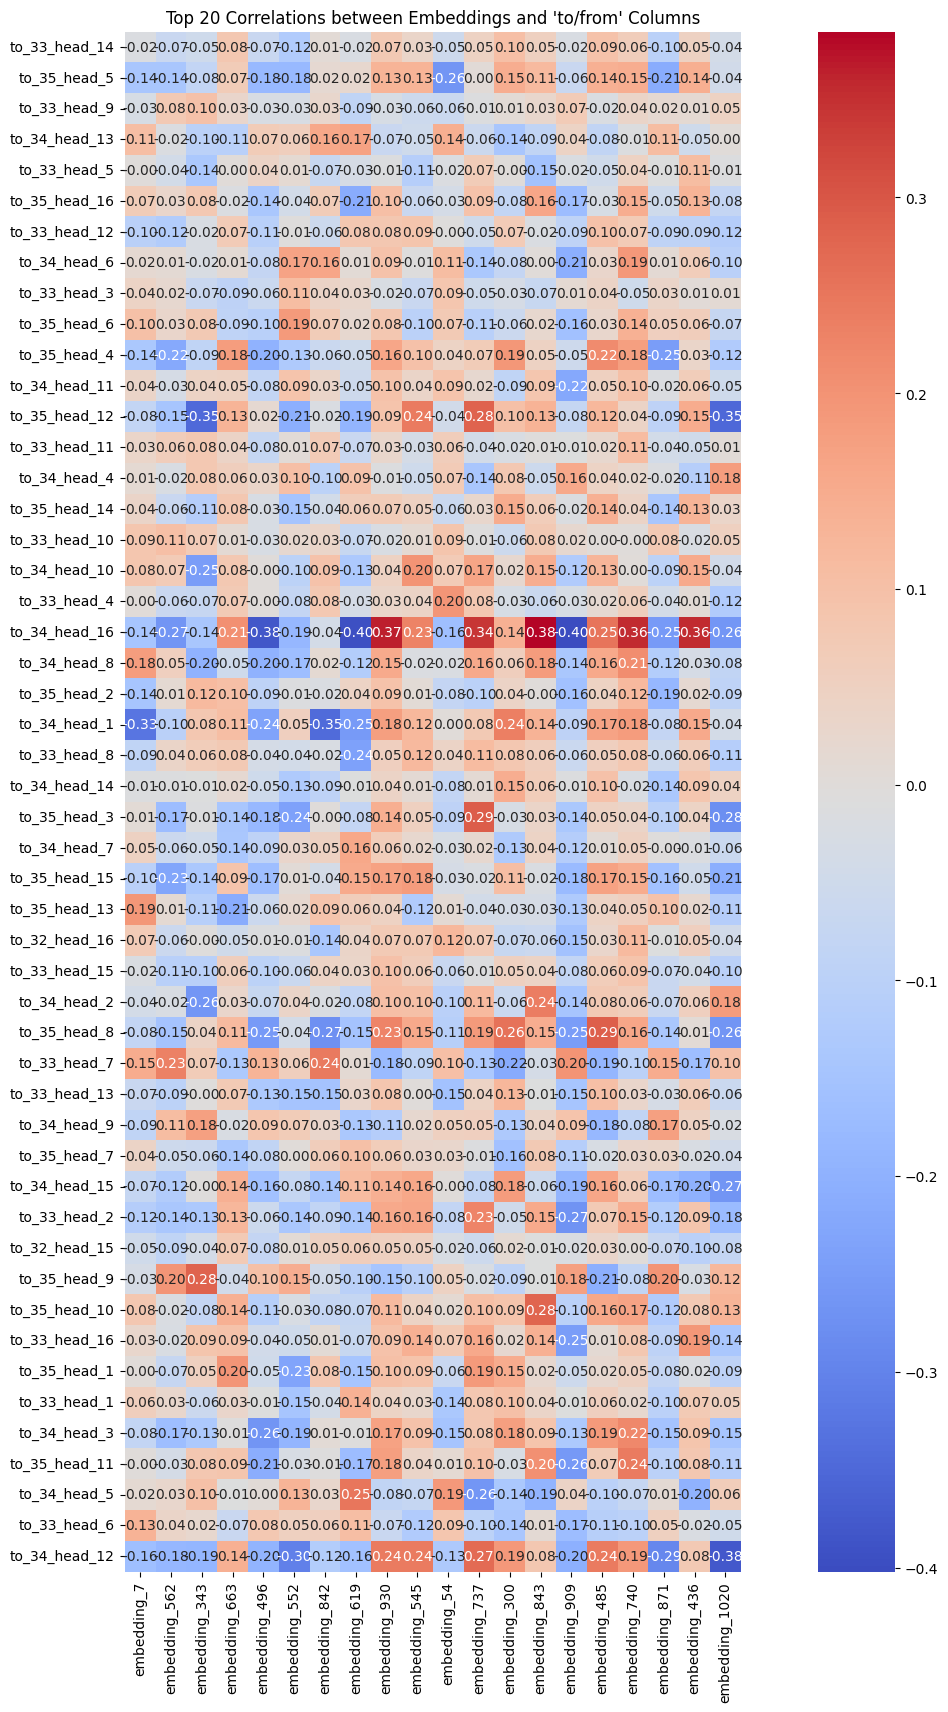

In [ ]:
correlation_matrix_to = correlation_matrix.drop(["position"]+['re_position']+ embedding_cols+ from_cols, axis = 0)
correlation_matrix_to = correlation_matrix_to.drop(from_cols+to_cols, axis = 1)

# Filter the correlation matrix to select top correlations
N = 20  # Number of top correlations to visualize
top_correlations = correlation_matrix_to[embedding_cols].abs().unstack().groupby(level=0).sum().sort_values(ascending=True)[:N]

# Extract the column and row names of the top correlations
top_correlation_names = top_correlations.index
embedding_columns = set([name[0] for name in top_correlation_names])
# to_from_columns = set([name[1] for name in top_correlation_names[:20]])
# Create a subset correlation matrix with the top correlations
subset_correlation_matrix = correlation_matrix_to.loc[set(to_cols[-50:]), set(list(top_correlation_names))]

# Plot the correlation heatmap for the subset
plt.figure(figsize=(20, 20))
sns.heatmap(subset_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f"Top {N} Correlations between Embeddings and 'to/from' Columns")
plt.show()

In [ ]:
embedding_cols

по модулю

<ipython-input-24-4a22f2e95ddf>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  subset_correlation_matrix = correlation_matrix_to.loc[to_from_columns, embedding_columns]


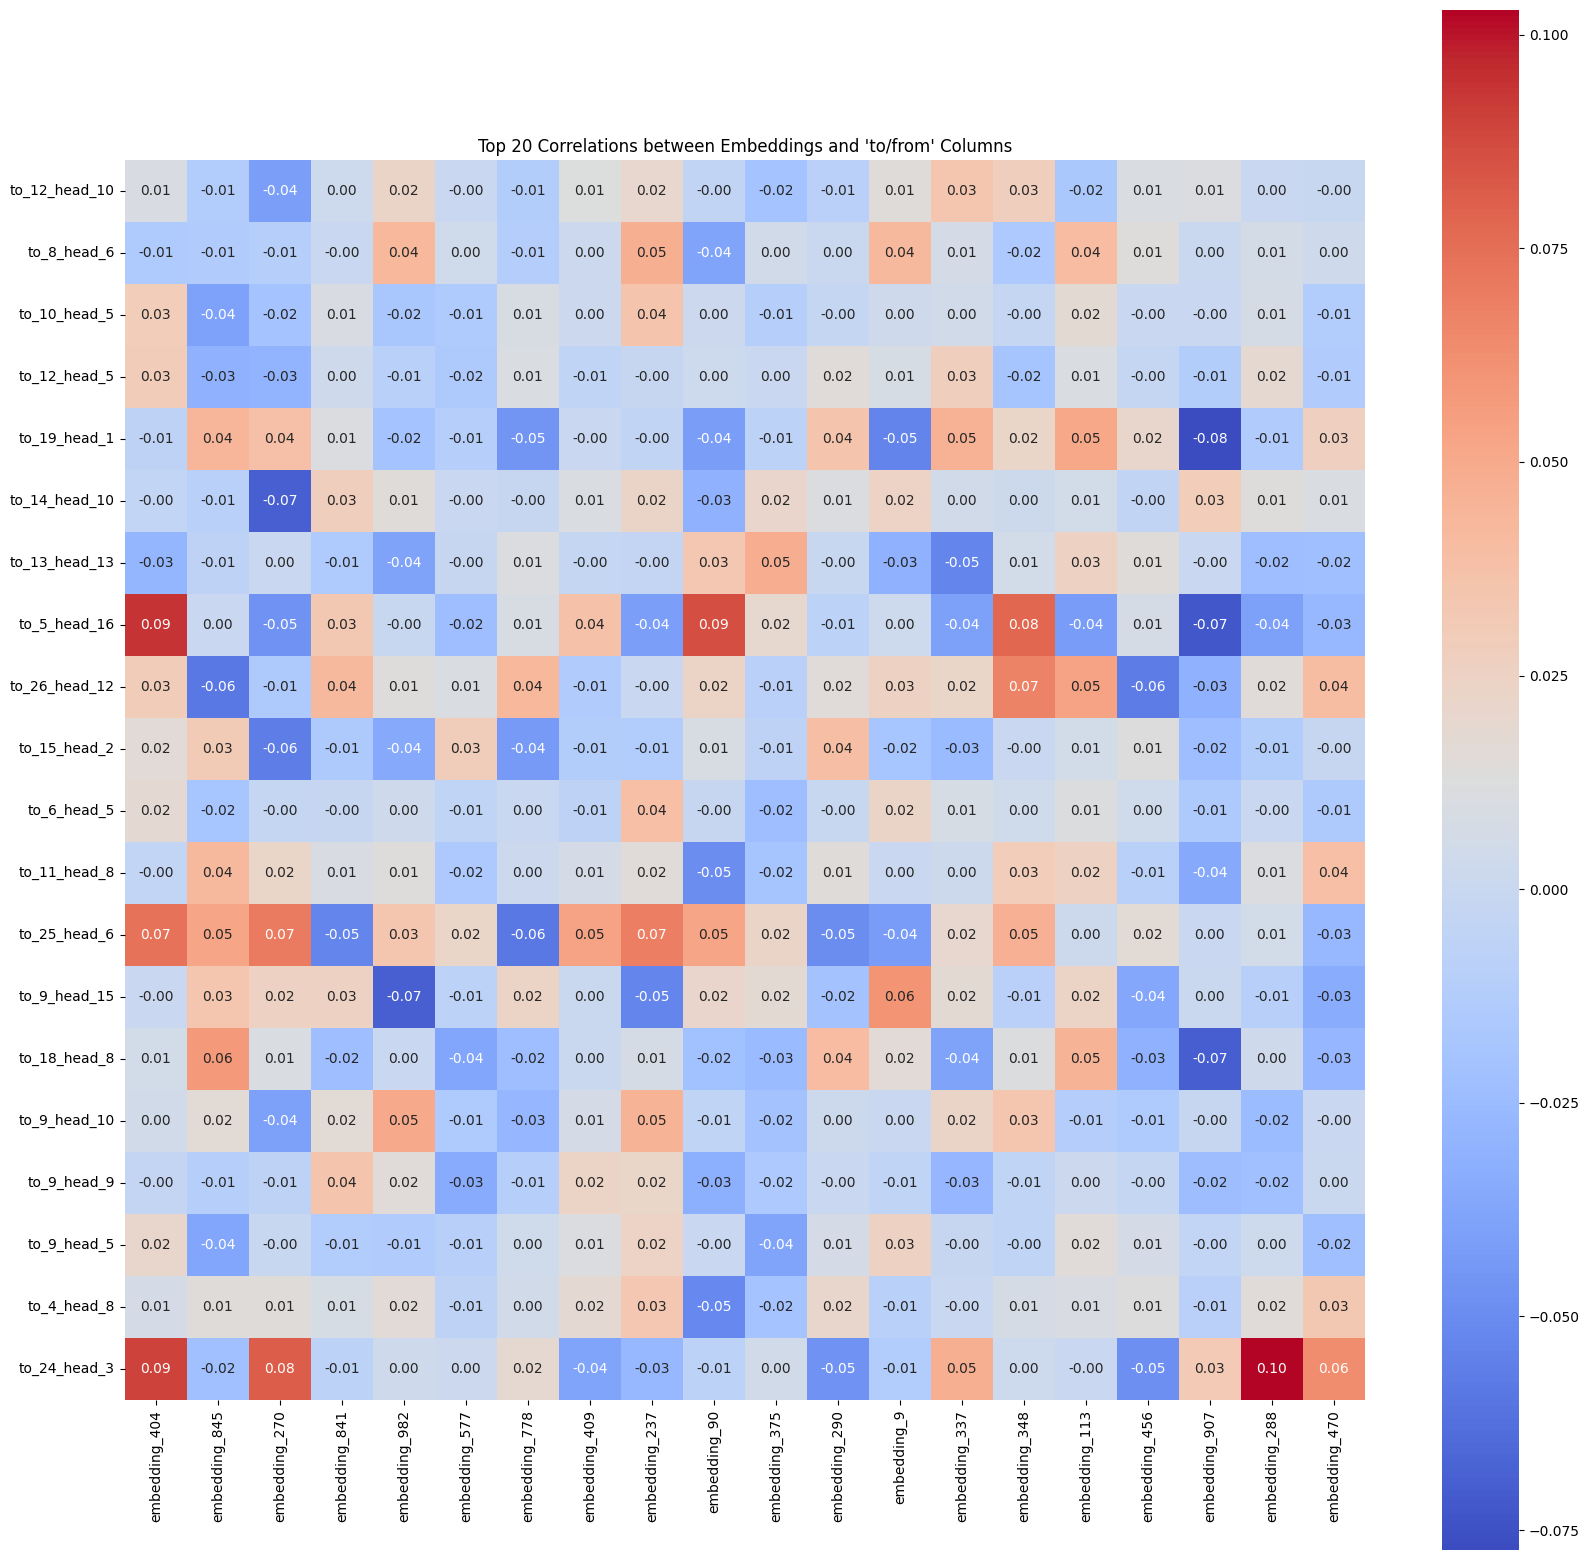

In [ ]:
correlation_matrix_to = correlation_matrix.drop(["position"]+['re_position']+ embedding_cols+ from_cols, axis = 0)
correlation_matrix_to = correlation_matrix_to.drop(from_cols+to_cols, axis = 1)

# Filter the correlation matrix to select top correlations
N = 20  # Number of top correlations to visualize
top_correlations = correlation_matrix_to[embedding_cols].abs().unstack().sort_values(ascending=True)[:N]

# Extract the column and row names of the top correlations
top_correlation_names = top_correlations.index
embedding_columns = set([name[0] for name in top_correlation_names])
to_from_columns = set([name[1] for name in top_correlation_names[:20]])
# Create a subset correlation matrix with the top correlations
subset_correlation_matrix = correlation_matrix_to.loc[to_from_columns, embedding_columns]

# Plot the correlation heatmap for the subset
plt.figure(figsize=(20, 20))
sns.heatmap(subset_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f"Top {N} Correlations between Embeddings and 'to/from' Columns")
plt.show()

## кореляция с ембедингом по головам

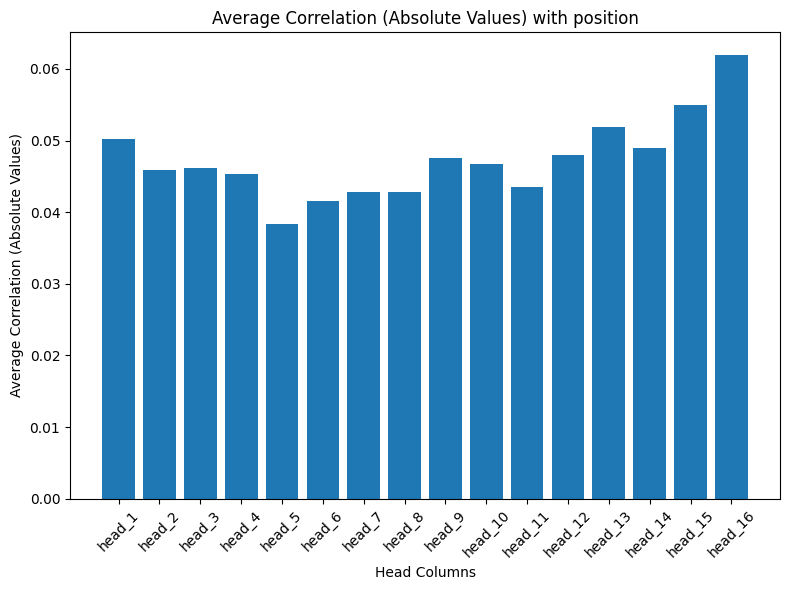

In [157]:
correlation_matrix_new = correlation_matrix.drop(["position"]+ embedding_cols, axis = 0)
correlation_matrix_new = correlation_matrix_new.drop(to_cols+from_cols, axis = 1)
# Calculate the average correlation within each group
# fig, axes = plt.subplots(4, 4, figsize=(15, 30))
# plt.subplots_adjust(wspace=0.5)

heads_mean = []
for num, i in enumerate(head_cols):
  heads_mean.append(np.abs(correlation_matrix.loc[i, embedding_cols]).mean().mean())

plt.figure(figsize=(8, 6))
plt.bar([f'head_{i}' for i in range(1, len(head_cols)+1)], heads_mean)
plt.xlabel('Head Columns')
plt.ylabel('Average Correlation (Absolute Values)')
plt.title('Average Correlation (Absolute Values) with position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Позиции и средний attention

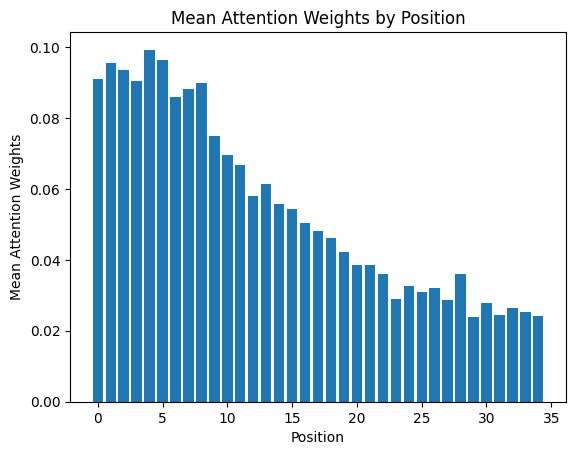

In [172]:
# Assuming you have a dataset named "df" with position and attention_weights columns
position_col = 'position'
attention_weights_cols = to_cols

# Calculate the mean attention weights for each position
mean_attention_weights = df[attention_weights_cols].mean(axis=1)

# Create a new dataframe with position and mean_attention_weights columns
mean_attention_df = pd.DataFrame({position_col: df[position_col], 'mean_attention_weights': mean_attention_weights})

# Group the data by position and calculate the mean of mean_attention_weights
grouped_df = mean_attention_df.groupby(position_col)['mean_attention_weights'].mean().reset_index()

# Plot the mean attention weights for each position
plt.bar(grouped_df[position_col], grouped_df['mean_attention_weights'])
plt.xlabel('Position')
plt.ylabel('Mean Attention Weights')
plt.title('Mean Attention Weights by Position')
plt.show()

## Влияние позиции на средний по головам

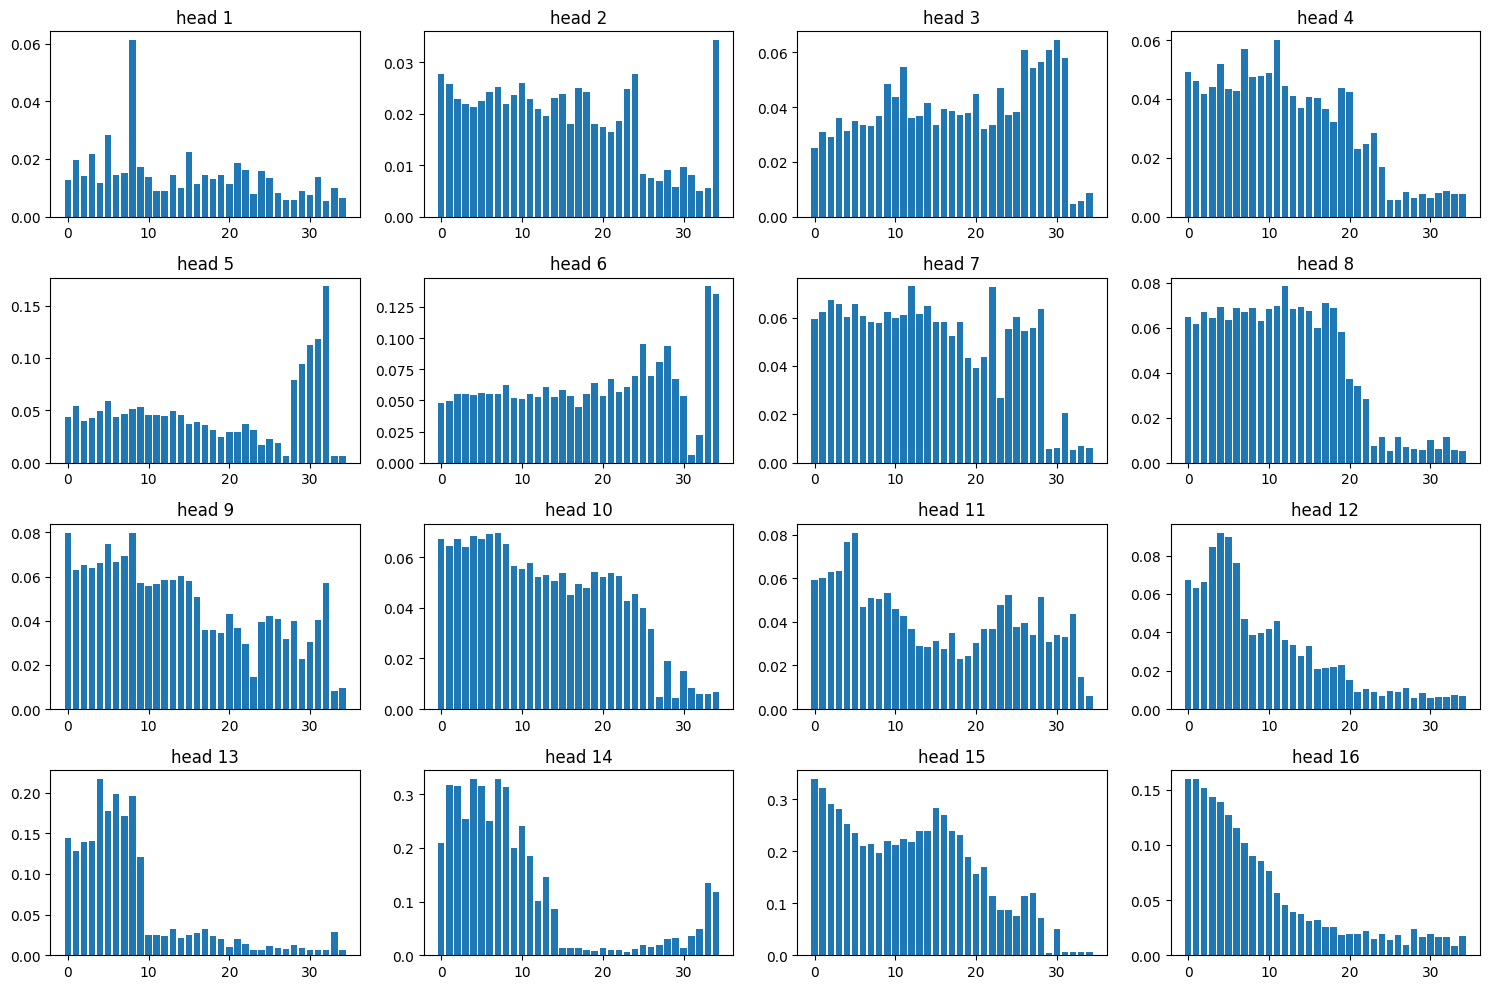

In [180]:
correlation_matrix_new = correlation_matrix.drop(["position"]+ embedding_cols, axis = 0)
correlation_matrix_new = correlation_matrix_new.drop(to_cols+from_cols, axis = 1)
# Calculate the average correlation within each group
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
# plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
heads_mean = []
for num, i in enumerate(head_cols):
  position_col = 'position'
  attention_weights_cols = i
  # Calculate the mean attention weights for each position
  mean_attention_weights = df[attention_weights_cols].mean(axis=1)
  # Create a new dataframe with position and mean_attention_weights columns
  mean_attention_df = pd.DataFrame({position_col: df[position_col], 'mean_attention_weights': mean_attention_weights})
  # Group the data by position and calculate the mean of mean_attention_weights
  grouped_df = mean_attention_df.groupby(position_col)['mean_attention_weights'].mean().reset_index()
  # Plot the mean attention weights for each position
  ax = axes[num]
  ax.set_title(f'head {num+1}')
  ax.bar(grouped_df[position_col], grouped_df['mean_attention_weights'])
  # axes[num%4, num//4].set_yticks([])
  # axes[num%4, num//4].set_yticklabels(axes[num%4, num//4].get_yticklabels(), size=10)  # Adjust size as needed

plt.tight_layout()
plt.show()